In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as Image
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

In [6]:
from pytorchtools import EarlyStopping
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os.path
from pandas.core.frame import DataFrame
from skimage import io, transform, color
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
import torch

In [7]:
torch.cuda.empty_cache() 

In [8]:
train_csv = 'train.csv'
test_csv = 'test.csv'
breed_csv = 'breed_labels.csv'
images_dir = 'train_images'

In [9]:
dtype = {'PetID': int}

In [10]:
train_set = pd.read_csv(train_csv, dtype = {'PetID': str})

In [11]:
train_set['PetID'] = train_set['PetID'].apply(lambda x: '{0:0>9}'.format(x))

In [12]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [13]:
breed_df = pd.read_csv(breed_csv)

In [14]:
merged_df = pd.merge(train_set, breed_df, left_on='Breed1', right_on='BreedID')

In [ ]:
# breed name and id in same table

In [ ]:
rows = 2
cols = 5
adoption_speed = 2
breed_id = 189     #support breed

for adoption_speed in range(1,5):
    filtered_df = train_set[(train_set.Breed1 == 20) & (train_set.Type == 1) & (train_set.AdoptionSpeed == adoption_speed) & (train_set.PhotoAmt > 0)]
    try:
        filtered_df = filtered_df.sample(rows * cols) #support small sample size
    except:
        continue
    
    image_set = np.split(filtered_df[['PetID', 'Breed1']], rows)

    fig, axarr = plt.subplots(rows, cols, figsize=(40,25))
    fig.suptitle(f'Adoption Speed: {adoption_speed}', fontsize=46)
    for ax, images in zip(axarr, image_set):
        for ax_one, (petId, breedID) in zip(ax, images.values): #suuport iteration
            img = Image.imread(Path(f"{images_dir}/{petId}-1.jpg"))
            breed_name = breed_df[breed_df.BreedID == breedID].BreedName.values[0]
            ax_one.imshow(img)
            ax_one.set_title(breed_name, fontsize=26)

In [ ]:
# visualize decision tree
# train image classfie accordingly
# make data generator for fast ai

In [15]:
class PetFinderDataset(Dataset):
    def __init__(self, csv: str, images_dir: str, image_count: int, transforms=None, test_set=False):
        self.csv = pd.read_csv(csv)
        self.images_dir = images_dir
        self.transforms = transforms
        self.image_count = image_count
        self.df = self.csv[self.csv.PhotoAmt > 0].reset_index()
        self.n_classes = self.df.nunique()
        self.test_set = test_set
        
    def set_df(self, df):
        self.df = df
             
    def __len__(self):
        return len(self.df)
    
    def __read_image__(self, pet_id: str, number: int):
        img_name = f'{pet_id}-{number}.jpg'
        img_path = os.path.join(self.images_dir, img_name)
        sample = io.imread(img_path)
        if sample.ndim == 2:
            sample = color.gray2rgb(sample)
            
        if self.transforms:
            sample = self.transforms(sample)
        return sample
    
    def __dummy__(self):
        zeros = torch.zeros((256, 256, 3), dtype=torch.uint8)
        if self.transforms:
            sample = self.transforms(zeros)
        return sample
    
    def __getitem__(self, idx):
        
        image_bunch = []
        pet_id = self.df.loc[idx, 'PetID']
        if self.test_set:
            adoption_speed = 0
        else:
            adoption_speed = self.df.AdoptionSpeed.iloc[idx]
        
        if self.image_count <= self.df.loc[idx, 'PhotoAmt']:          
            images_present = self.image_count
            for img_no in range(1, images_present + 1):
                image = self.__read_image__(pet_id, img_no)
                image_bunch.append(image)
        else:
            images_present = self.df.loc[idx, 'PhotoAmt'].astype(int)
            
            img_diff = self.image_count - images_present
            image_bunch += [self.__dummy__() for _ in range(img_diff)]
            
            for img_no in range(1, images_present + 1):
                image = self.__read_image__(pet_id, img_no)
                image_bunch.append(image)
                
        image_bunch = torch.stack(image_bunch).permute(1, 0, 2, 3)
        return (image_bunch, adoption_speed)

                

In [16]:
image_count = 4

In [17]:
size = 256

In [18]:
eval_transformation = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [19]:
data_df = train_set[(train_set.PhotoAmt > 0)]

In [39]:
 X_train, X_test, y_train, y_test = train_test_split(data_df, data_df.AdoptionSpeed, test_size=0.2, random_state=1)

In [21]:
value_counts  = X_train.AdoptionSpeed.value_counts()

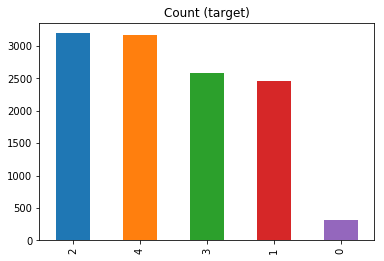

In [22]:
value_counts.plot(kind='bar', title='Count (target)')

In [40]:
mean = int(value_counts.mean())

In [41]:
grouped = X_train.groupby('AdoptionSpeed')

In [42]:
new_df = None

for name, group in grouped:
    if len(group) > mean:
        combined = group.sample(mean)
    else:
        rem = group.sample(mean - len(group), replace= True)
        combined =  pd.concat([group, rem], axis=0)
    if new_df is None:
        new_df = combined
    else:
         new_df = pd.concat([new_df, combined], axis=0)

In [43]:
new_df.AdoptionSpeed.value_counts()

4    2344
3    2344
2    2344
1    2344
0    2344
Name: AdoptionSpeed, dtype: int64

In [64]:
ds = PetFinderDataset(train_csv, images_dir, image_count, eval_transformation)

In [65]:
ds.set_df(new_df.reset_index())

In [66]:
dataloader = DataLoader(ds, batch_size=4, num_workers=0)

In [45]:
test_ds = PetFinderDataset(test_csv, images_dir, image_count, eval_transformation)

In [58]:
test_ds.set_df(X_test.reset_index())

In [59]:
testloader = DataLoader(test_ds, batch_size=4, num_workers=0)

In [52]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1=nn.Conv3d(3,64,kernel_size=(3,3,3),stride=1,padding=(1,1,1))
        self.maxpool1=nn.MaxPool3d(kernel_size=(1,2,2),stride=(1,2,2))
        self.conv2=nn.Conv3d(64,128,kernel_size=(3,3,3),stride=1,padding=(1,1,1))
        self.maxpool2=nn.MaxPool3d(kernel_size=(2,2,2),stride=(2,2,2))
        self.conv3=nn.Conv3d(128, 64,kernel_size=(3,3,3),stride=1,padding=(1,1,1))
        self.maxpool3=nn.MaxPool3d(kernel_size=(2,2,2),stride=(2,2,2))
        
        self.dense1_bn = nn.BatchNorm1d(100)

        self.num_out_maxpool5 = 64 * 1 * 28 * 28
        self.fc1=nn.Linear(self.num_out_maxpool5,2048)#TBA
        self.fc2=nn.Linear(2048,1024)
        self.fc3=nn.Linear(1024,512)
        self.fc4=nn.Linear(512,5)
        
        self.dropout=nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        x = x.view(-1, self.__num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def __num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:       # Get the products
            num_features *= s
        return num_features

In [53]:
model = Model().cuda()

In [36]:
SAVE_PATH = Path('model.pt')

In [50]:
weights = torch.load(SAVE_PATH)

In [54]:
model.load_state_dict(weights)

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [69]:
# normalize data
# beagle images
# incorrect images
# batch norm
# train only on doggies
# check for accuracy and shit
# validation set and crap
# Balance Dataset for adoption speed
# Transfer Learning
# train cats later
# try different breeds
# add breed classfier and train
# connect to catboost
# structured data fast ai
# early stopping
# fix readign images from csv
# split train - test before cat and dog
# put results in csv, train with cat boost and print
# randomize images and their order
# checkpoints

In [67]:
train_loader = dataloader
valid_loader = testloader

In [ ]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

patience = 5
n_epochs = 15
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

test_acc = 0.0

for epoch in range(1, n_epochs + 1):

    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for batch, (data, target) in enumerate(train_loader, 1):
        print(f'Train Batch: {batch}')
        
        data = Variable(data.cuda())
        target = Variable(target.cuda())
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # record training loss
        train_losses.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        data = Variable(data.cuda())
        target = Variable(target.cuda())
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        _, prediction = torch.max(output.data, 1)
        test_acc += torch.sum(prediction == target.data)
        # record validation loss
        valid_losses.append(loss.item())
        
    
    test_acc = test_acc.double() / len(X_test)
    print(f'Accuracy: {test_acc}')

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.5f} ' +
                 f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Train Batch: 1
Train Batch: 2
Train Batch: 3
Train Batch: 4
Train Batch: 5
Train Batch: 6
Train Batch: 7
Train Batch: 8
Train Batch: 9
Train Batch: 10
Train Batch: 11
Train Batch: 12
Train Batch: 13
Train Batch: 14
Train Batch: 15
Train Batch: 16
Train Batch: 17
Train Batch: 18
Train Batch: 19
Train Batch: 20
Train Batch: 21
Train Batch: 22
Train Batch: 23
Train Batch: 24
Train Batch: 25
Train Batch: 26
Train Batch: 27
Train Batch: 28
Train Batch: 29
Train Batch: 30
Train Batch: 31
Train Batch: 32
Train Batch: 33
Train Batch: 34
Train Batch: 35
Train Batch: 36
Train Batch: 37
Train Batch: 38
Train Batch: 39
Train Batch: 40
Train Batch: 41
Train Batch: 42
Train Batch: 43
Train Batch: 44


In [229]:
torch.max(output.data, 1)

(tensor([12.2461,  6.8897, 21.1981, 31.9723], device='cuda:0'),
 tensor([4, 4, 4, 4], device='cuda:0'))

In [230]:
prediction == target.data

tensor([0, 0, 0, 0], device='cuda:0', dtype=torch.uint8)

In [ ]:
# TODO: test train set

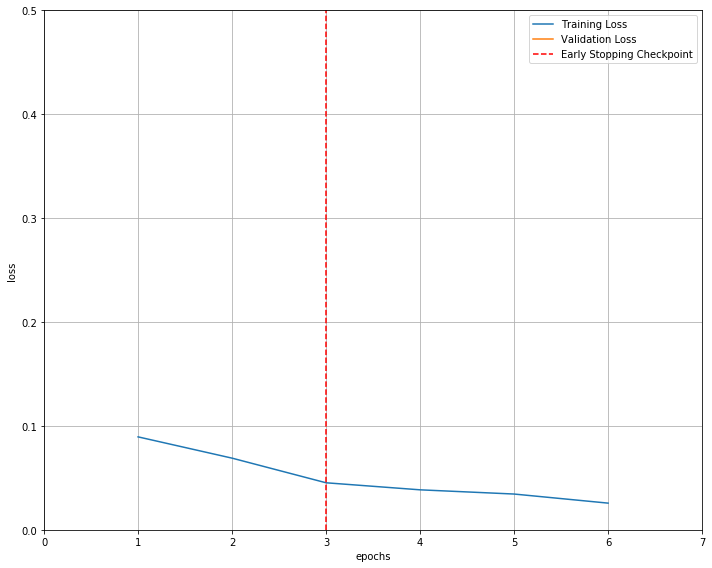

In [244]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
net.state_dict()

In [ ]:
torch.save(net.state_dict(), SAVE_PATH)

In [60]:
model.eval()

test_acc = 0.0
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        print(f'Batch {i}')

        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)

        test_acc += torch.sum(prediction == labels.data)

    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc.double() / len(X_test)
    print(f'Accuracy: {test_acc}')

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


In [ ]:
train_set = pd.read_csv(test_csv)

In [ ]:
photo_df = train_set[train_set.PhotoAmt > 0 ]

In [ ]:
sliced_df = photo_df[['PetID', 'PhotoAmt']]

In [113]:
import pathlib

In [114]:
images_path = pathlib.Path('./train_images')

In [125]:
img_files = os.listdir(images_path)

In [170]:
temp = set()
not_found = set()

for index, row in dog_set.iterrows():
    petID = row.loc['PetID']
    photo_no = int(row['PhotoAmt'])
    for no in range(1, photo_no + 1):
        img_path = Path(images_path, f'{petID}-{no}.jpg')
        if img_path.exists():
            temp.add(str(img_path))
        else:
            not_found.add(str(img_path))

In [171]:
len(not_found)

0

In [166]:
train_set[train_set.PetID == '1.06E+150']

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed


In [ ]:
not_found

In [ ]:
difference = img_files - temp

In [ ]:
list(not_found)[:10]

In [ ]:
list(difference)[:10]

In [ ]:
import re

def extract_id(path):
        m = re.search('\\\\(.+?)-\d+.jpg', path)
        if m:
            return m.group(1)

In [ ]:
import difflib

In [ ]:
str_diff = set(map(extract_id, (map(str, difference))))
str_not_found = set(map( extract_id, map(str, not_found)))

In [ ]:
replace = {}
for missing in str_not_found:
    matches = difflib.get_close_matches(missing, str_diff, n=3, cutoff=0.45)
    if matches:
        print(missing, matches[0])
        replace[missing] = matches[0]

In [ ]:
replace

In [ ]:
replace.keys()

In [ ]:
train_set.replace(replace, inplace = True)

In [ ]:
train_set = train_set[~train_set.PetID.isin(str_not_found)]

In [ ]:
train_set.to_csv('new_train.csv')